# Style Transfer

Based on this tutorial: [Neural style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)

The seminal paper: [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

## Main Idea

1. In a convolutional NN layers closer to the output represent the most abstract description of the image in terms of the most high-level patterns. 
2. Activation in the convolutional layers closer to the input represents the low-level details of the image (texutre, and such like).
3. We can interpret the activation from the near-to-output convolutional layers (1) as a content, and correlation between (1) and (2) as an artistic style. 
4. We can learn this correlation from arbitrary sample of images, take "content" (1) from another image and recreate low-level details (2) using the learned correlation.

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import IPython.display as display

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

Convert tensor to `PIL.Image`:

In [3]:
import PIL.Image
import numpy as np

def tensor_to_image(tensor):
    """Convert tensor with values from [0, 1.0] to PIL.Image."""
    tensor = tensor * 255 # Scale values
    tensor = np.array(tensor, dtype=np.uint8) 
    while len(tensor.shape) > 3:
        if tensor.shape[0] != 1:
            raise ValueError(f"Cannot convert shape into (N, N, 3): {tensor.shape}")
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Get the images:

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

Load the image:

In [5]:
def load_image(path:str, max_dim:int=512):
    """Load image as tensor."""
    # Load raw image as tensor
    image = tf.io.read_file(path) # File content as tensor
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Calculate desired image shape based on max_dim
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    # Scale the image
    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    return image
    


def show_pair(content, style, figsize=(5, 5)):
    if len(content.shape) > 3:
        content = tf.squeeze(content, axis=0)
    if len(style.shape) > 3:
        style = tf.squeeze(style, axis=0)
    
    figure = plt.figure(figsize=figsize, dpi=80)
    
    content_axes = figure.add_subplot(1, 2, 1)
    content_axes.imshow(content)
    content_axes.set_title("Content")
    content_axes.axis('off')
    
    style_axes = figure.add_subplot(1, 2, 2)
    style_axes.imshow(style)
    style_axes.set_title("Style")
    style_axes.axis('off')
    
    return figure

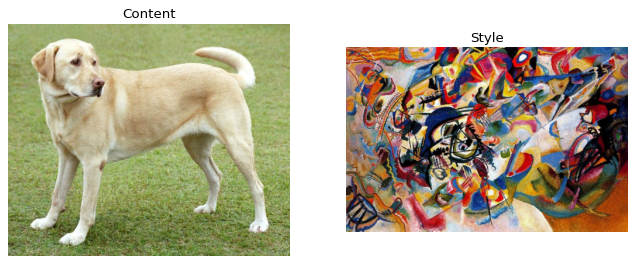

In [6]:
content_image = load_image(content_path)
style_image = load_image(style_path)
figure = show_pair(content_image, style_image, figsize=(10, 10))

## Fast Style Transfer using TF-Hub

Before implementing the algorithm, let's see how the predefined solution from the TensorFlow Hub works:

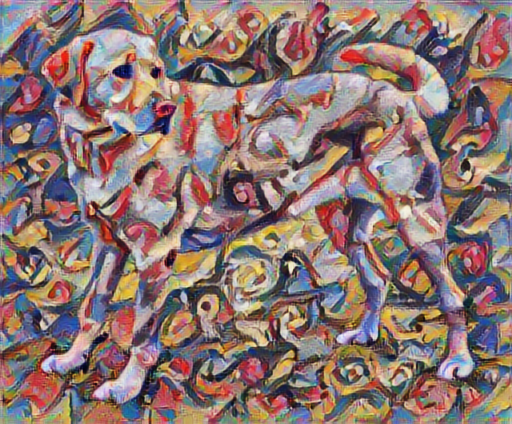

In [20]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Defome Content and Style Representations

Load a pretrained [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) model and test it on out data:

In [8]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [9]:
def vgg_predict(image, vgg):
    image = tf.keras.applications.vgg19.preprocess_input(image * 255)
    image = tf.image.resize(image, (224, 224))
    prediction_probabilities = vgg(image)
    decoded_top_5_predictions = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
    return [(name, prob) for (_, name, prob) in decoded_top_5_predictions]

In [10]:
vgg_predict(content_image, vgg)

[('Labrador_retriever', 0.49319038),
 ('golden_retriever', 0.23679946),
 ('kuvasz', 0.036320675),
 ('Chesapeake_Bay_retriever', 0.02415596),
 ('Greater_Swiss_Mountain_dog', 0.018633286)]

In [11]:
vgg_predict(style_image, vgg)

[('sarong', 0.43196467),
 ('kimono', 0.29907995),
 ('apron', 0.037471283),
 ('shower_curtain', 0.035834786),
 ('poncho', 0.026742833)]

In [12]:
vgg_predict(stylized_image, vgg)

[('jigsaw_puzzle', 0.16993059),
 ('shower_cap', 0.07956166),
 ('apron', 0.06021653),
 ('bib', 0.050963666),
 ('umbrella', 0.03969645)]

Ahahaha! The VGG19 doesn't see the masked Labrador! XD

![Art of Masking](./docs/lol_masking.jpg)

### Unboxing the Black Box

Now let's dissect the VGG19 Model.

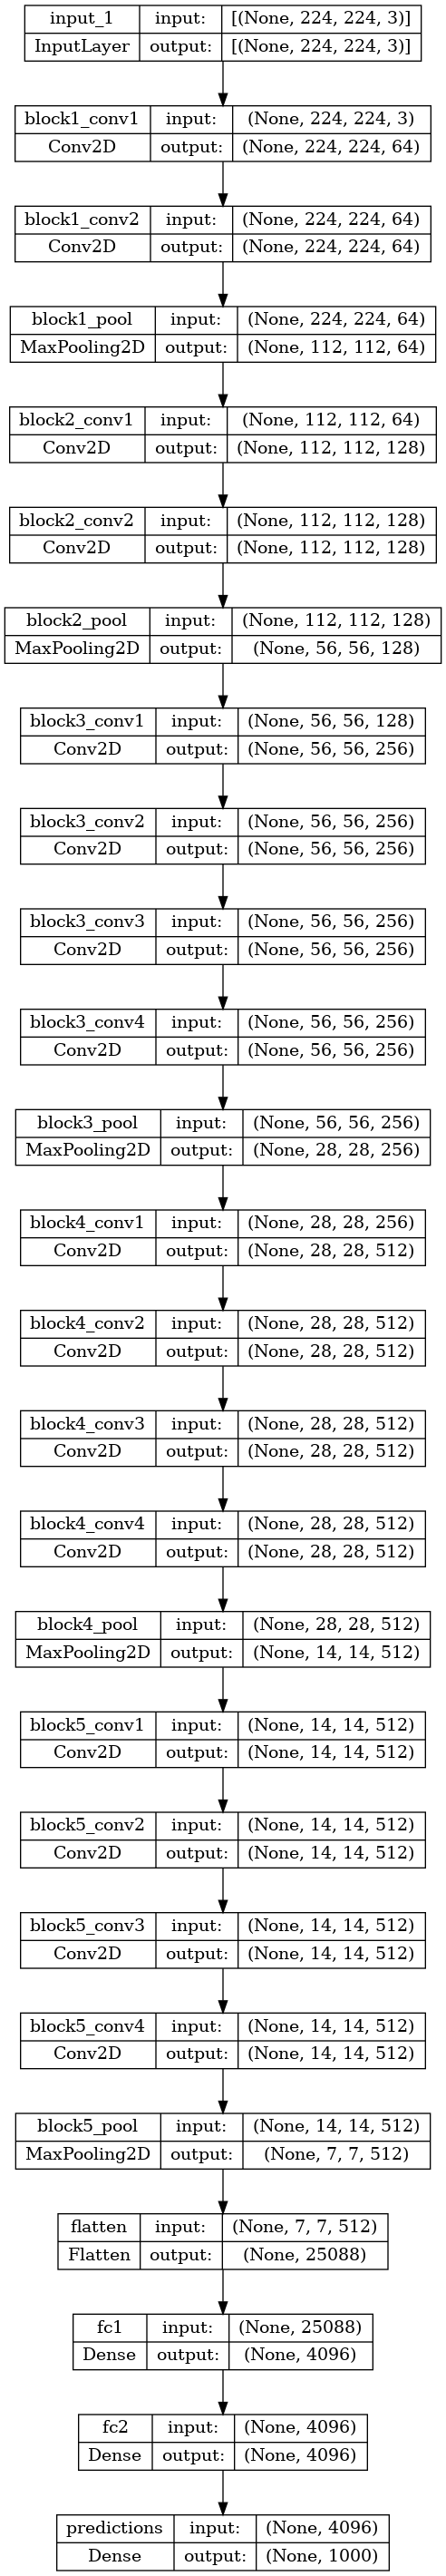

In [13]:
keras.utils.plot_model(vgg, show_shapes=True)

In [14]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
layer_names = [layer.name for layer in vgg.layers]

In [15]:
layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [16]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the Model

In [17]:
def extract_layers(layer_names, model) -> keras.Model:
    """Extract layers from the model."""
    outputs = [model.get_layer(name).output for name in layer_names]
    return tf.keras.Model(inputs=[model.input], outputs=outputs)

vgg.trainable = False
style_extractor = extract_layers(style_layers, vgg)

style_outputs = style_extractor(content_image*255)

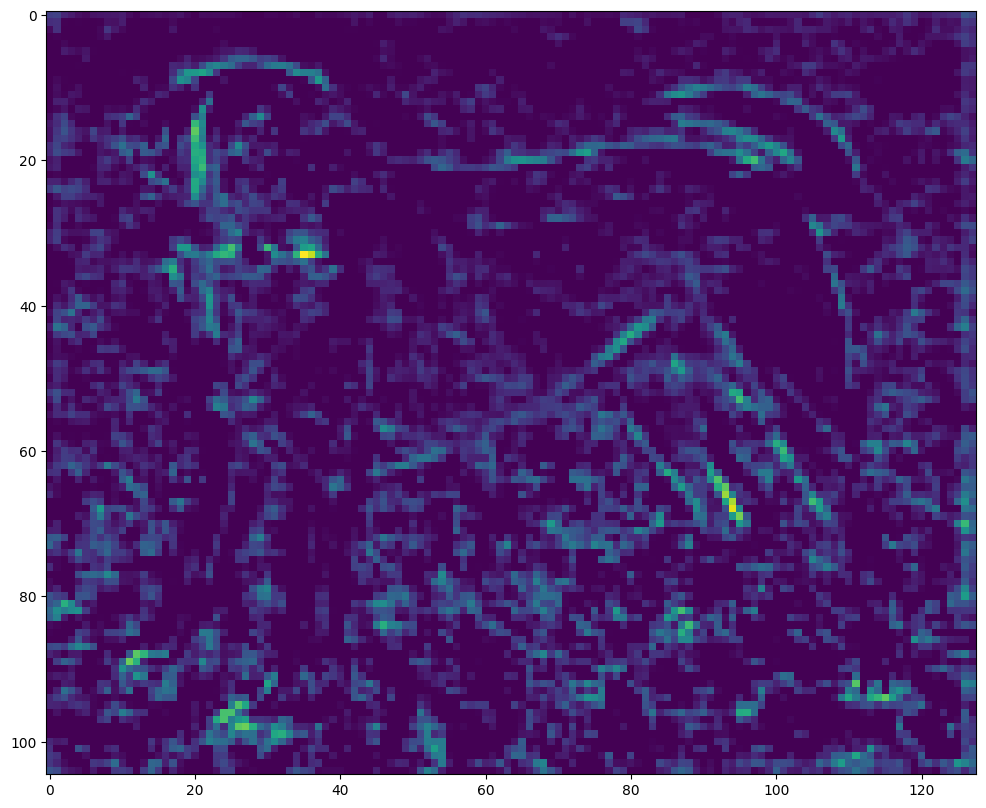

In [18]:
plt.imshow(tf.squeeze(style_outputs[2])[:, :, 21])

## Calculate Style

